# Forecast a multivariate time series

In [57]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)
%config InlineBackend.figure_format = 'retina'

Num GPUs Available:  1


## Raw data

In [85]:
data = pd.read_csv("data/item1213.csv", index_col=0).iloc[:, 1:]
data.columns = ['m0', 'qty1', 'qty2', 'qty3']
data.tail()

,m0,qty1,qty2,qty3
period_id,,,,
1255,0.2405,0.2207,0.0608,0.0
1256,0.4851,0.4583,0.0057,0.0
1257,0.0948,0.0523,0.0523,0.0
1258,0.1740,0.1386,0.0156,0.0
1259,0.1174,0.1174,0.0000,0.0


### Features considered

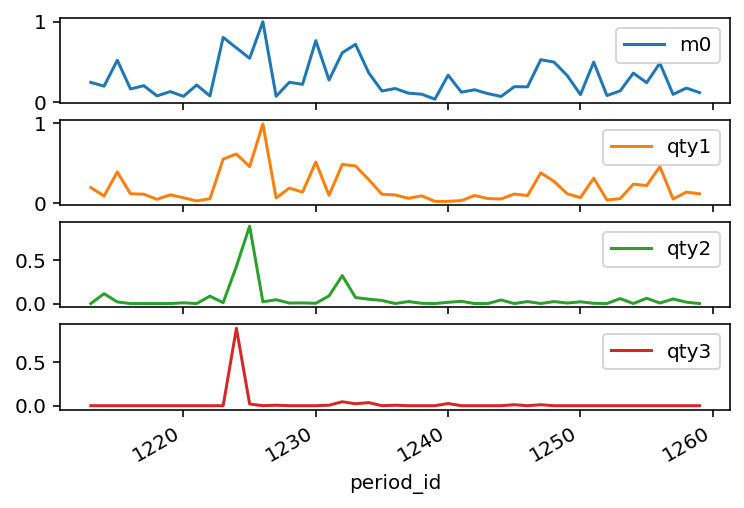

In [86]:
features_considered = ['m0', 'qty1', 'qty2', 'qty3']
features = data[features_considered]
features.index = data.index
features.plot(subplots=True)
plt.show()

## Preprocessing

### Standardization

In [87]:
dataset = tf.keras.utils.normalize(features.values)

### Multi-Step model

In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past ten periods. However, here, the model needs to learn to predict the m0 for the next 3 months.

In [88]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    if end_index is None:
        end_index = len(dataset) - target_size + 1
    else:
        start_index = start_index + history_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [89]:
# dataset = features.values
TRAIN_SPLIT = 38
past_history = 10
future_target = 4
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 0], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [90]:
print('Shape of x_train')
print(x_train_multi.shape)
print('\nSingle window of past history')
print(x_train_multi[0])
print('\nShape of y_train_multi')
print(y_train_multi.shape)
print('\nTarget of first instance')
print(y_train_multi[0])

Shape of x_train
(28, 10, 4)

Single window of past history
[[0.78174074 0.62360357 0.         0.        ]
 [0.80693086 0.36882446 0.46133623 0.        ]
 [0.79863039 0.60115925 0.02823208 0.        ]
 [0.81092887 0.58514474 0.         0.        ]
 [0.87409655 0.48575223 0.         0.        ]
 [0.84625134 0.53278389 0.         0.        ]
 [0.77905449 0.62695622 0.         0.        ]
 [0.71854826 0.6900909  0.0863884  0.        ]
 [0.99122382 0.13219432 0.         0.        ]
 [0.60226581 0.43514493 0.66927183 0.        ]]

Shape of y_train_multi
(28, 4)

Target of first instance
[0.82414297 0.50190062 0.47790574 0.70905501]


### Shuffle the data

In [91]:
tf.random.set_seed(13)
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [92]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = list(range(-len(history), 0))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
             label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
               label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

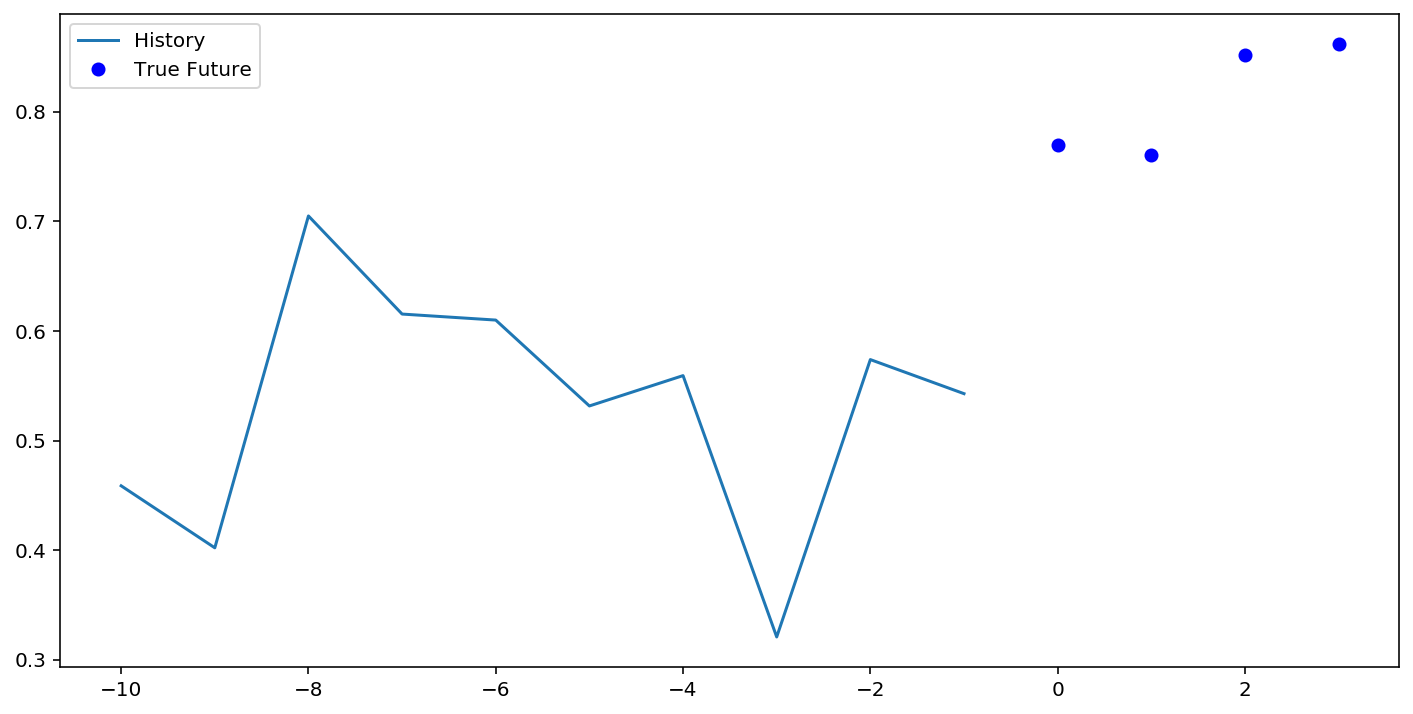

In [93]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

## Building RNN

In [168]:
tf.random.set_seed(42)
multi_step_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(16, return_sequences=True, input_shape=x_train_multi.shape[-2:]),
    tf.keras.layers.LSTM(8, activation='relu'), 
#     tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4)
])
multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
# multi_step_model.compile(optimizer='sgd', loss='mse')

In [169]:
EVALUATION_INTERVAL = 200
EPOCHS = 10
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

# multi_step_history = multi_step_model.fit(x_train_multi, y_train_multi, epochs=20)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 3s 17ms/step - loss: 0.1797 - val_loss: 0.0844
Epoch 2/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0731 - val_loss: 0.0983
Epoch 3/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0691 - val_loss: 0.0958
Epoch 4/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0672 - val_loss: 0.0845
Epoch 5/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0657 - val_loss: 0.0855
Epoch 6/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0643 - val_loss: 0.0931
Epoch 7/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0631 - val_loss: 0.0781
Epoch 8/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0621 - val_loss: 0.0883
Epoch 9/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0613 - val_loss: 0.0870
Epoch 10/10
200/200 [==============================] - 2

## Evaluation

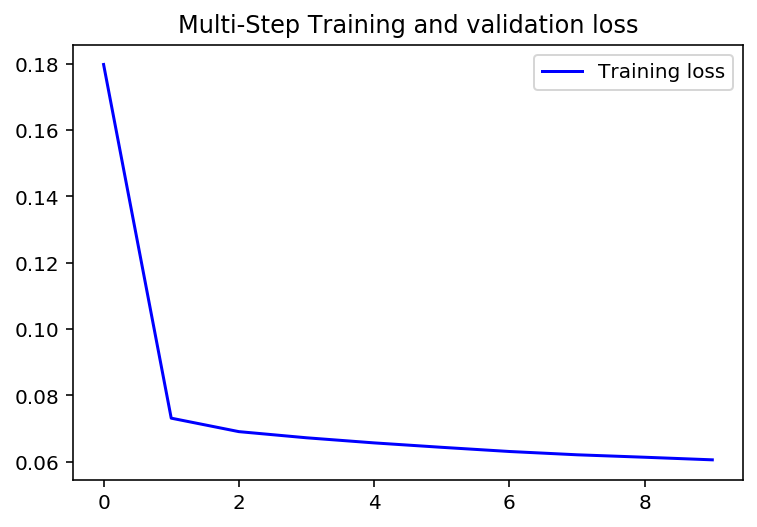

6/6 [==============================] - 0s 41ms/sample - loss: 0.0853


In [170]:
def plot_train_history(history, title, val=False):
    loss = history.history['loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    if val == True:
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()
    
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')
mse_test = multi_step_model.evaluate(x_val_multi, y_val_multi)

In [171]:
y_pred_train = multi_step_model.predict(x_train_multi)
y_pred_val = multi_step_model.predict(x_val_multi)

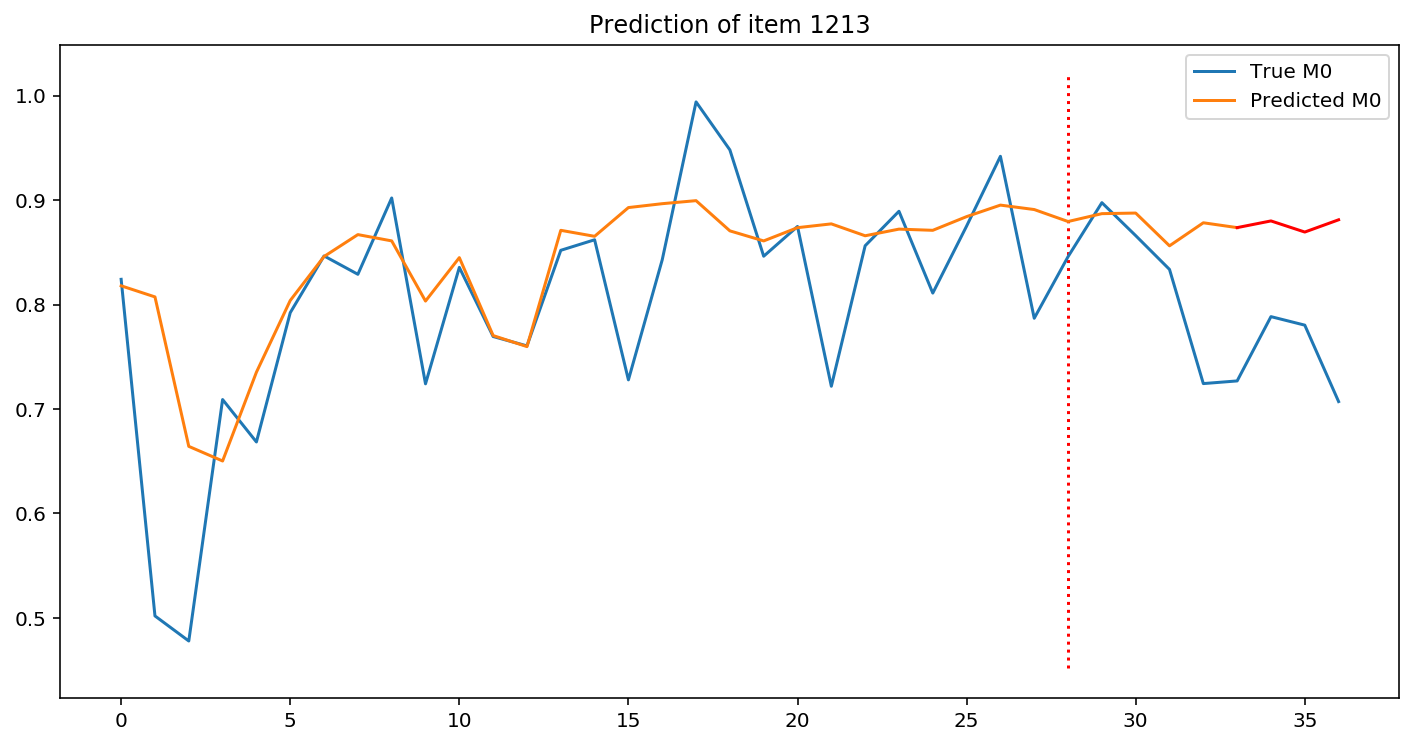

In [172]:
plt.figure(figsize=(12, 6))
plt.plot(np.append(y_train_multi[:, 0], np.append(y_val_multi[:, 0], y_val_multi[-1, 1:])), label='True M0')
plt.plot(np.append(y_pred_train[:, 0], y_pred_val[:, 0]), label='Predicted M0')
plt.plot(range(33, 37), y_pred_val[-1], color='red')
ax = plt.gca()
ymin, ymax = ax.get_ylim()
plt.vlines(len(y_train_multi), ymin, ymax, linestyles="dotted", color='r')
plt.legend()
plt.title("Prediction of item 1213")
plt.show()

### Accuracy

In [108]:
y_pred_val

array([[0.7837242 , 0.7682252 , 0.840836  , 0.7841195 ],
       [0.8087307 , 0.77873594, 0.770184  , 0.79532325],
       [0.81490576, 0.7797528 , 0.77570003, 0.78326744],
       [0.787946  , 0.7433081 , 0.76378566, 0.77152205],
       [0.7587005 , 0.71983135, 0.7767728 , 0.78142536],
       [0.7395289 , 0.71514654, 0.79770225, 0.7795619 ]], dtype=float32)

In [109]:
y_val_multi

array([[0.84583439, 0.8975234 , 0.86596117, 0.83361142],
       [0.8975234 , 0.86596117, 0.83361142, 0.72432735],
       [0.86596117, 0.83361142, 0.72432735, 0.72687443],
       [0.83361142, 0.72432735, 0.72687443, 0.78842418],
       [0.72432735, 0.72687443, 0.78842418, 0.78026655],
       [0.72687443, 0.78842418, 0.78026655, 0.70710678]])

In [110]:
def acc(y_test, y_pred):
    acc = np.ones([6, 4])
    for i in np.arange(len(y_pred)):
        for index, value in enumerate(y_pred[i]): 
            acc[i, index] = min(value, y_test[i, index])/max(value, y_test[i, index])
    return acc

In [111]:
acc(y_val_multi, y_pred_val)

array([[0.92656932, 0.8559389 , 0.97098579, 0.94062949],
       [0.90106923, 0.89927351, 0.92391247, 0.91073327],
       [0.94104192, 0.93539121, 0.93377248, 0.92800287],
       [0.94521976, 0.97446445, 0.95167331, 0.97856213],
       [0.95469471, 0.99031046, 0.98522194, 0.99851706],
       [0.98288848, 0.9070581 , 0.97814259, 0.90705665]])